## Home Price Prediction - Data Analysis & Cleanup

#### Imports

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as mplplot
import seaborn as sb
import xgboost as xg
import warnings

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings('ignore')

#### Load Train and Test Data

In [10]:
house_price_train = pd.read_csv("housing_ca.csv")
#house_price_test = pd.read_csv("Data/kaggle_input/test.csv")

#### Dimensions

In [11]:
print(house_price_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  int64  
 3   total_rooms         20640 non-null  int64  
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  int64  
 6   households          20640 non-null  int64  
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  int64  
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(4), int64(5), object(1)
memory usage: 1.6+ MB
None


#### House Price Dataset Shape (rows [Homes] cols[Dimensions])

In [12]:
house_price_train.shape

(20640, 10)

#### Data Munging

In [13]:
house_count = house_price_train.shape[0]
dimensions = house_price_train.columns.values

whole_dimensions = pd.DataFrame() # has value for all houses
partial_dimensions = pd.DataFrame() # has value for more than 50% of the houses
insufficient_dimensions = pd.DataFrame() # has values for less than 50% of the houses

#-------------------------------------------------------------------------------------------------
for dimension in dimensions:
    
    dimension_values = house_price_train[dimension]
    dimension_value_count = dimension_values.count()
    
    if dimension_value_count == house_count:
        whole_dimensions[dimension] = dimension_values
    elif dimension_value_count > house_count * 0.5:
        partial_dimensions[dimension] = dimension_values
    else:
        insufficient_dimensions[dimension] = dimension_values
#-------------------------------------------------------------------------------------------------

numerical_dimension_count = len(house_price_train.select_dtypes(include=['number']).columns.values)
qualitative_dimension_count = len(house_price_train.select_dtypes(include=['O']).columns.values)

print(f'Number of dimensions before reduction: { house_price_train.shape[1]}')
print(f'Number of numerical dimensions before reduction: {numerical_dimension_count}')
print(f'Number of qualitative dimensions before reduction: {qualitative_dimension_count}')
print(f'Number of Insufficient dimensions: {len(insufficient_dimensions.columns)}')

# Exclude all dimensions with insufficient values
house_price_train = house_price_train.drop(insufficient_dimensions.columns.values, axis=1)

numerical_dimensions = house_price_train.select_dtypes(include=['number'])
qualitative_dimensions = house_price_train.select_dtypes(include=['object'])

# Get dimensions having more than 30% of values as zero
#--------------------------------------------------------------------------------------------------------
zero_value_dimensions = {}
for numerical_dimension in numerical_dimensions:
    
    dimension_zero_value_ratio = (numerical_dimensions.loc[
                                      numerical_dimensions[numerical_dimension] == 0, 
                                      numerical_dimension
                                    ].count()/house_count)
    if dimension_zero_value_ratio > 0.30:
        zero_value_dimensions.update({numerical_dimension: dimension_zero_value_ratio})
#--------------------------------------------------------------------------------------------------------

print(f'Number of Zero value dimensions: {len(zero_value_dimensions.keys())}')    

# Remove dimensions having more than 30% of values as zero
#--------------------------------------------------------------------------------------------------------
for zero_value_dimension in zero_value_dimensions:
    numerical_dimensions = numerical_dimensions.drop([zero_value_dimension], axis=1)
    house_price_train = house_price_train.drop([zero_value_dimension], axis=1)
    if dimension in partial_dimensions:
        partial_dimensions.drop([zero_value_dimension], axis=1)
#--------------------------------------------------------------------------------------------------------        
print(f'Number of dimensions after reduction [Dropped: Id, Insufficient Dimensions, Zero Value Dimensions] : { house_price_train.shape[1]}')

Number of dimensions before reduction: 10
Number of numerical dimensions before reduction: 9
Number of qualitative dimensions before reduction: 1
Number of Insufficient dimensions: 0
Number of Zero value dimensions: 0
Number of dimensions after reduction [Dropped: Id, Insufficient Dimensions, Zero Value Dimensions] : 10


TypeError: '<' not supported between instances of 'pandas._libs.interval.Interval' and 'float'

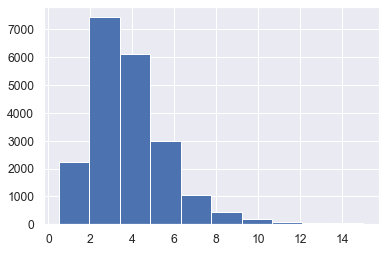

In [30]:
house_price_train['median_income'].hist()


dd = pd.cut(house_price_train['median_income'], bins=[0., 1.5, 3.0, 4.5, 6., np.inf])
dd.hist()
print(dd)
#ff = pd.cut(house_price_train['median_income'], 5, labels=[1, 2, 3, 4, 5])
#ff.hist()

#### Correlation between numerical dimensions and median house value

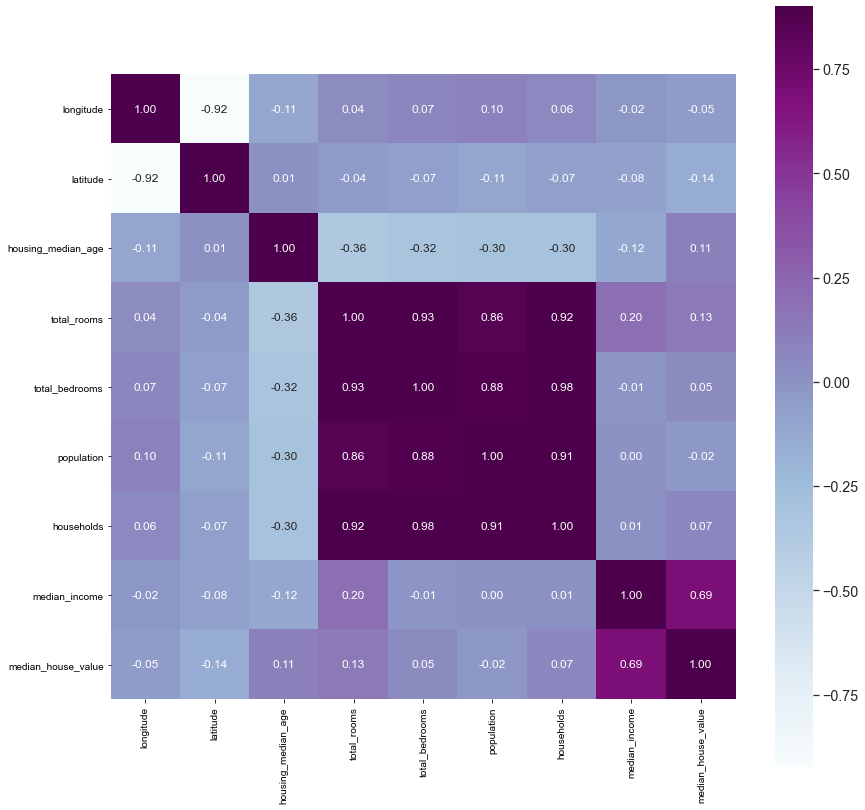

In [14]:
correlation_matrix = numerical_dimensions.corr()
figure, axis = mplplot.subplots(figsize=(14,14))
sb.set(font_scale=1.3)
sb.heatmap(correlation_matrix, vmax=.9, annot=True, square=True, annot_kws={'size': 12}, fmt='.2f', cmap="BuPu")
mplplot.show()

#### Top 10 dimensions that has the most impact on home sale price

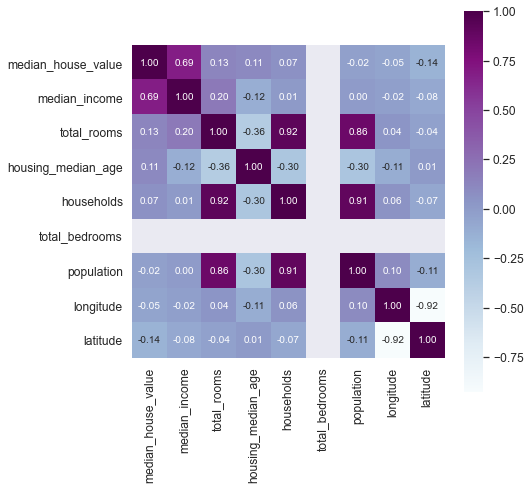

In [19]:
strongly_correlated_dimensions = correlation_matrix.nlargest(10, 'median_house_value')['median_house_value'].index
strong_correlation_matrix = np.corrcoef(numerical_dimensions[strongly_correlated_dimensions].values.T)
figure, axis = mplplot.subplots(figsize=(7,7))
sb.set(font_scale=1.1)
sb.heatmap(strong_correlation_matrix, annot=True, square=True, 
           annot_kws={'size': 10}, fmt='.2f', cmap="BuPu", 
           yticklabels=strongly_correlated_dimensions.values,
           xticklabels=strongly_correlated_dimensions.values)
mplplot.show()

#### Scatter plot for top 7 dimensions that is highly correated to sale price and visualize linearity

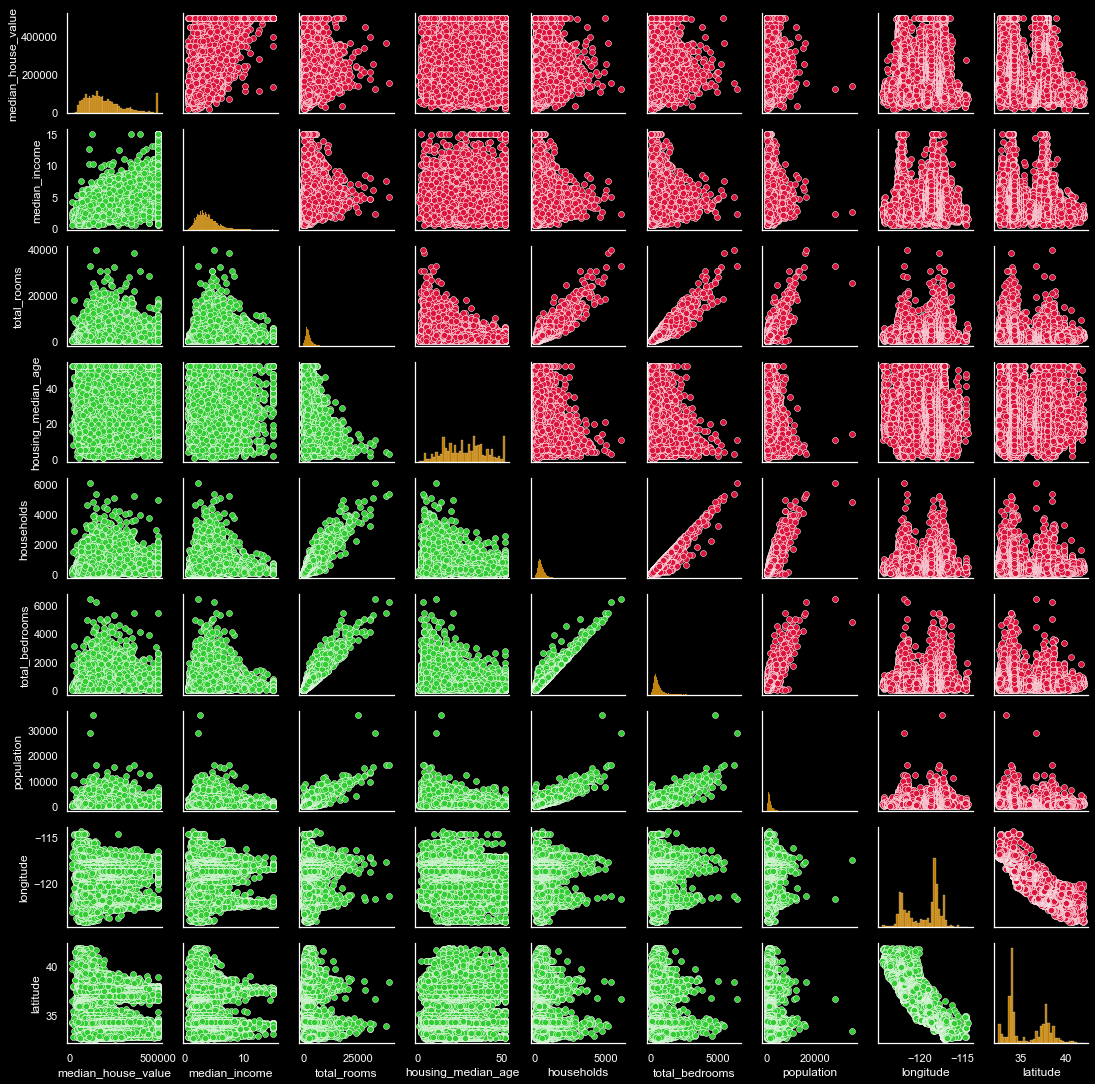

In [16]:
sb.set_theme('notebook', style='dark')
mplplot.style.use("dark_background")
grid_plot = sb.PairGrid(numerical_dimensions[strongly_correlated_dimensions.values], size=1.7)
grid_plot.map_upper(sb.scatterplot, color='crimson')
grid_plot.map_lower(sb.scatterplot, color='limegreen')
grid_plot.map_diag(sb.histplot, color='orange')
mplplot.show()

In [31]:
import http.client
import json

conn = http.client.HTTPSConnection("m0rnqlct08.execute-api.us-east-2.amazonaws.com")
payload = json.dumps({
  "housing_age": 50,
  "rooms_per_household": 5,
  "median_income": 4.0057848,
  "inland": 0,
  "island": 0,
  "near_bay": 0,
  "near_ocean": 1,
  "less_than_1_hr": 0,
  "housing_age_sq_ft": 2500
})
headers = {
  'Content-Type': 'application/json'
}
conn.request("POST", "/prod/predict-home-value-function", payload, headers)
res = conn.getresponse()
data = res.read()
print(data.decode("utf-8"))

{"statusCode": 200, "predicted_home_value": 277040.158328}
